# Evaluating Image Understanding at Scale with Structured Outputs

*An end-to-end example of **Multimodal Structured Outputs** with Daft and Qwen3-VL-8B*



## Introduction

**Structured Outputs** refers to a family of features that enables language models to respond in a constrained format. While language models continue to improve and demonstrate emergent abilities, their unpredictable nature makes them difficult to integrate with traditional software systems. Most real-world AI use cases leverage structured outputs to some extent, whether that be to execute tool calls or adhere to Pydantic Models.

The underlying technology is called **guided decoding**, using logits to control model output by adjusting token probabilities to enforce constraints. This can be done through logit biases, Finite State Machines (FSM), or other techniques that interact with the model's probability distribution.

Structured Outputs generally supports 5 constraint strategies:
- **Basic Python Types**: `int`, `float`, `bool`...
- **Multiple Choices**: using `Literal` or `Enum`
- **JSON Schemas**: using Pydantic models or dataclasses
- **Regex**
- **Context-free Grammars**

### What We'll Build

We'll evaluate [Qwen3-VL](https://github.com/QwenLM/Qwen3-VL)'s image understanding using a multiple choice subset ofHuggingFace's [The Cauldron dataset](https://huggingface.co/datasets/HuggingFaceM4/the_cauldron) a massive collection of 50 vision-language datasets. 

Our pipeline will:

1. Run structured output inference on image+text prompts
2. Conduct an **ablation study** (with vs. without images) to isolate image understanding
3. Classify results into diagnostic quadrants
4. Use **VLM-as-a-Judge** to explain failures


### Table of Contents

1. [Setup](#1-setup)
2. [Data Loading](#2-data-loading)
3. [Preprocessing](#3-preprocessing)
4. [Structured Outputs with `prompt`](#4-structured-outputs-with-prompt)
5. [Ablation Study](#5-ablation-study)
6. [Scale with Daft Cloud](#6-scale-with-daft-cloud)
7. [Conclusion](#7-conclusion)



## 1. Setup


In [ ]:
%pip install -q daft openai numpy pillow python-dotenv ipykernel ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

# Configuration
MODEL_ID = "Qwen/Qwen3-VL-8B-Instruct"
LIMIT = 50  # Keep low for interactive demo

# HuggingFace Inference Provider (hosted Qwen3-VL endpoints)
OPENAI_API_KEY = os.getenv["HF_TOKEN"]
OPENAI_BASE_URL = "https://router.huggingface.co/v1"

In [ ]:
import daft

# Set the OpenAI-compatible provider
daft.set_provider("openai", api_key=OPENAI_API_KEY, base_url=OPENAI_BASE_URL)

## 2. Data Loading

[The Cauldron](https://huggingface.co/datasets/HuggingFaceM4/the_cauldron) is a massive collection of 50 vision-language datasets spanning:
- Visual question answering
- OCR & document understanding
- Chart/figure understanding
- Reasoning & math
- And more...

We'll start with the **AI2D** subset—science diagrams with multiple-choice questions.


In [ ]:
df_raw = daft.read_huggingface("HuggingFaceM4/the_cauldron/ai2d").limit(LIMIT).collect()
df_raw.show(3)

"imagesList[Struct[bytes: Binary, path: String]]","textsList[Struct[user: String, assistant: String, source: String]]"
"[{bytes: b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD""...,path: None,}]","[{user: Question: What do respiration and combustion give outChoices:A. OxygenB. Carbon dioxideC. NitrogenD. HeatAnswer with the letter.,assistant: Answer: B,source: AI2D,}]"
"[{bytes: b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD""...,path: None,}]","[{user: Question: From the given food web, name any two herbivores?Choices:A. coyote, bobcatB. dingo, jack rabbitC. dingo, bobcatD. roadrunner&jack rabbitAnswer with the letter.,assistant: Answer: D,source: AI2D,}, {user: Question: In the given food web, which are the organism that only eaten roadrunner?Choices:A. dingo, jack rabbitB. coyote, bobcatC. dingo, bobcatD. snake, jack rabbitAnswer with the letter.,assistant: Answer: B,source: AI2D,}, {user: Question: Name a herbivore from the given food web?Choices:A. cactusB. kangaroo ratC. snakeD. bobcatAnswer with the letter.,assistant: Answer: B,source: AI2D,}, {user: Question: Name a producer from the given food web?Choices:A. bobcatB. snakeC. road runnerD. barrel cactusAnswer with the letter.,assistant: Answer: D,source: AI2D,}, {user: Question: Name an omnivore from the given food web?Choices:A. dingoB. bobcatC. cactusD. kangarooAnswer with the letter.,assistant: Answer: D,source: AI2D,}, {user: Question: What is a predator of the roadrunner?Choices:A. kangarooB. coyoteC. dingoD. cactusAnswer with the letter.,assistant: Answer: B,source: AI2D,}, {user: Question: What will happen if kangroo rats goes extinct?Choices:A. Cactus count will decreaseB. Dessert plants growth will decresseC. Snake population will increaseD. Snake population will decreaseAnswer with the letter.,assistant: Answer: D,source: AI2D,}, {user: Question: What would be most affected if the cactus all died?Choices:A. coyoteB. dingoC. kangaroo ratD. snakeAnswer with the letter.,assistant: Answer: C,source: AI2D,}, {user: Question: Which among the below is a producer in the food chain diagram shown?Choices:A. Kangaroo ratB. RoadrunnerC. Dessert grassD. SnakeAnswer with the letter.,assistant: Answer: C,source: AI2D,}, {user: Question: Which is a producer?Choices:A. CoyoteB. Desert GrassC. KangarooD. DingoAnswer with the letter.,assistant: Answer: B,source: AI2D,}, {user: Question: Who would suffer without kangaroo rats?Choices:A. Desert GrassB. SnakeC. CactusD. RoadrunnerAnswer with the letter.,assistant: Answer: B,source: AI2D,}, {user: Question: desert grasses are known asChoices:A. consumerB. herbivoresC. omnivoresD. producerAnswer with the letter.,assistant: Answer: D,source: AI2D,}]"
"[{bytes: b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD""...,path: None,}]","[{user: Question: Anatomy One of a series of long curved bones occurring in 12 pairs in humans is called.Choices:A. diaphramB. lungC. noneD. ribsAnswer with the letter.,assistant: Answer: D,source: AI2D,}]"


## 3. Preprocessing

We need to:
1. Decode images into Daft's Image type
2. Extract the question, choices, and correct answer from the text


In [ ]:
from daft import col
from daft.functions import unnest

# Decode images
df_img = df_raw.explode(col("images"))
df_img = df_img.with_column("image", col("images")["bytes"].decode_image())

# Extract text fields (user question, assistant answer)
df_text = df_img.explode(col("texts")).select(unnest(col("texts")), "image")

# Parse the answer letter from "Answer: C" format
df_prep = df_text.with_column(
    "answer", 
    col("assistant").regexp_replace("Answer: ", "").lstrip().rstrip()
).collect()

df_prep.show(3)

## 4. Structured Outputs with `prompt`

Daft's `prompt` function scales OpenAI-compatible calls across dataframes. We'll use a Pydantic model to enforce structured output.

For more info: [API docs](https://docs.daft.ai/en/stable/api/functions/prompt/) | [User Guide](https://docs.daft.ai/en/stable/ai-functions/prompt/)


In [ ]:
from daft.functions import prompt
from pydantic import BaseModel, Field
import time

class ChoiceResponse(BaseModel):
    """Structured output for multiple choice answers."""
    choice: str  = Field(..., description="The letter of the correct choice (e.g., A, B, C, D)")

start = time.time()
df_results = df_prep.with_column(
    "result",
    prompt(
        messages=[col("image"), col("user")],
        model=MODEL_ID,
        use_chat_completions=True,
        return_format=ChoiceResponse,
    )
).limit(LIMIT).collect()
elapsed = time.time() - start

print(f"Processed {df_results.count_rows()} rows in {elapsed:.1f} seconds")

🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 Limit 50: 00:00 

🗡️ 🐟 Async UDF prompt-2e978dfe-d008-4b17-9958-86c99d47e110: 00:00 

Processed 50 rows in 5.4 seconds


In [12]:
# Evaluate correctness
df_eval = df_results.with_column(
    "is_correct", 
    col("result")["choice"].lstrip().rstrip() == col("answer").lstrip().rstrip()
)

accuracy = df_eval.where(col("is_correct")).count_rows() / df_eval.count_rows()
print(f"Accuracy (with image): {accuracy:.1%}")


🗡️ 🐟 Project: 00:00 

🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 Filter: 00:00 

🗡️ 🐟 Count: 00:00 

🗡️ 🐟 Project: 00:00 

🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 Project: 00:00 

🗡️ 🐟 Count: 00:00 

🗡️ 🐟 Project: 00:00 

Accuracy (with image): 90.0%


In [13]:
# Let's look at some results
df_eval.select("user", "image", "answer", col("result")["choice"].alias("predicted"), "is_correct").show(5)


## 5. Ablation Study

A simple accuracy score tells us *how often* the model is correct, but not *why*. To understand the contribution of image understanding, we'll conduct an **ablation study**—running the same prompts without images.

This lets us classify each example into four quadrants:

| Quadrant | With Image | Without Image | Interpretation |
|----------|------------|---------------|----------------|
| **Both Correct** | ✓ | ✓ | Question may be solvable from text alone |
| **Image Helped** | ✓ | ✗ | True image understanding |
| **Image Hurt** | ✗ | ✓ | Visual confusion |
| **Both Incorrect** | ✗ | ✗ | Hard question or model limitation |


In [14]:
# Run without images
SYSTEM_PROMPT_NO_IMAGE = "Respond to the multiple choice question with just the letter corresponding to the correct answer."

start = time.time()
df_ablation = df_eval.with_column(
    "result_no_image",
    prompt(
        messages=col("user"),
        system_message=SYSTEM_PROMPT_NO_IMAGE,
        model=MODEL_ID,
        use_chat_completions=True,
        return_format=ChoiceResponse,
    )
).with_column(
    "is_correct_no_image",
    col("result_no_image")["choice"].lstrip().rstrip() == col("answer").lstrip().rstrip()
).collect()
elapsed = time.time() - start

print(f"Processed {df_ablation.count_rows()} rows in {elapsed:.1f} seconds")


🗡️ 🐟 Project: 00:00 

🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 Async UDF prompt-cd355d0b-c522-48b5-ad70-eb0cadece14f: 00:00 

🗡️ 🐟 Project: 00:00 

Processed 50 rows in 21.1 seconds


In [15]:
# Compare accuracy
accuracy_no_image = df_ablation.where(col("is_correct_no_image")).count_rows() / df_ablation.count_rows()

print(f"Accuracy with image:    {accuracy:.1%}")
print(f"Accuracy without image: {accuracy_no_image:.1%}")
print(f"Delta:                  {accuracy - accuracy_no_image:+.1%}")


🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 Count: 00:00 

🗡️ 🐟 Project: 00:00 

🗡️ 🐟 Filter: 00:00 

🗡️ 🐟 Project: 00:00 

🗡️ 🐟 Project: 00:00 

Accuracy with image:    90.0%
Accuracy without image: 82.0%
Delta:                  +8.0%


In [17]:
from daft.functions import when, monotonically_increasing_id

# Classify into quadrants
df_classified = df_ablation.with_column(
    "id", monotonically_increasing_id()
).with_column(
    "quadrant",
    when((col("is_correct") == True) & (col("is_correct_no_image") == True), "Both Correct")
    .when((col("is_correct") == True) & (col("is_correct_no_image") == False), "Image Helped")
    .when((col("is_correct") == False) & (col("is_correct_no_image") == True), "Image Hurt")
    .otherwise("Both Incorrect")
)

# Show distribution
df_classified.groupby("quadrant").count().select("quadrant", col("id").alias("count")).show()


quadrantString,countUInt64
Image Helped,5
Both Correct,40
Image Hurt,1
Both Incorrect,4


In [ ]:
# Inspect cases where the image helped
df_classified.where(col("quadrant") == "Image Helped").select(
    "user", "image", "answer", 
    col("result")["choice"].alias("with_image"),
    col("result_no_image")["choice"].alias("without_image")
).show(3)


In [13]:
# Inspect cases where the image hurt
df_classified.where(col("quadrant") == "Image Hurt").select(
    "user", "image", "answer",
    col("result")["choice"].alias("with_image"),
    col("result_no_image")["choice"].alias("without_image")
).show(3)


In [32]:
# Show breakdown across all subsets with percentages
df_subset_totals = df_classified.groupby("subset").count().select(
    "subset",
    col("id").alias("total")
)

df_results = df_classified.groupby("subset", "quadrant").count().select(
    "subset", 
    "quadrant",
    col("id").alias("count")
).join(df_subset_totals, on="subset").with_column(
    "percentage",
    (col("count") / col("total") * 100)
).select("subset", "quadrant", "count", "percentage").collect()

df_results.show(12)

subsetString,quadrantString,countUInt64,percentageFloat64
ai2d,Image Helped,1355,18.158670597694986
ai2d,Both Incorrect,253,3.3905119270972928
ai2d,Both Correct,5742,76.94987938890378
ai2d,Image Hurt,112,1.5009380863039399
tqa,Image Helped,1629,25.131132366553533
...,...,...,...
tqa,Image Hurt,213,3.2860228324591176
scienceqa,Image Helped,1376,22.377622377622377
scienceqa,Image Hurt,144,2.3418442023093187
scienceqa,Both Incorrect,469,7.627256464465766


In [19]:
!pip install matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 25.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]



=== Creating Pie Charts for Each Subset ===


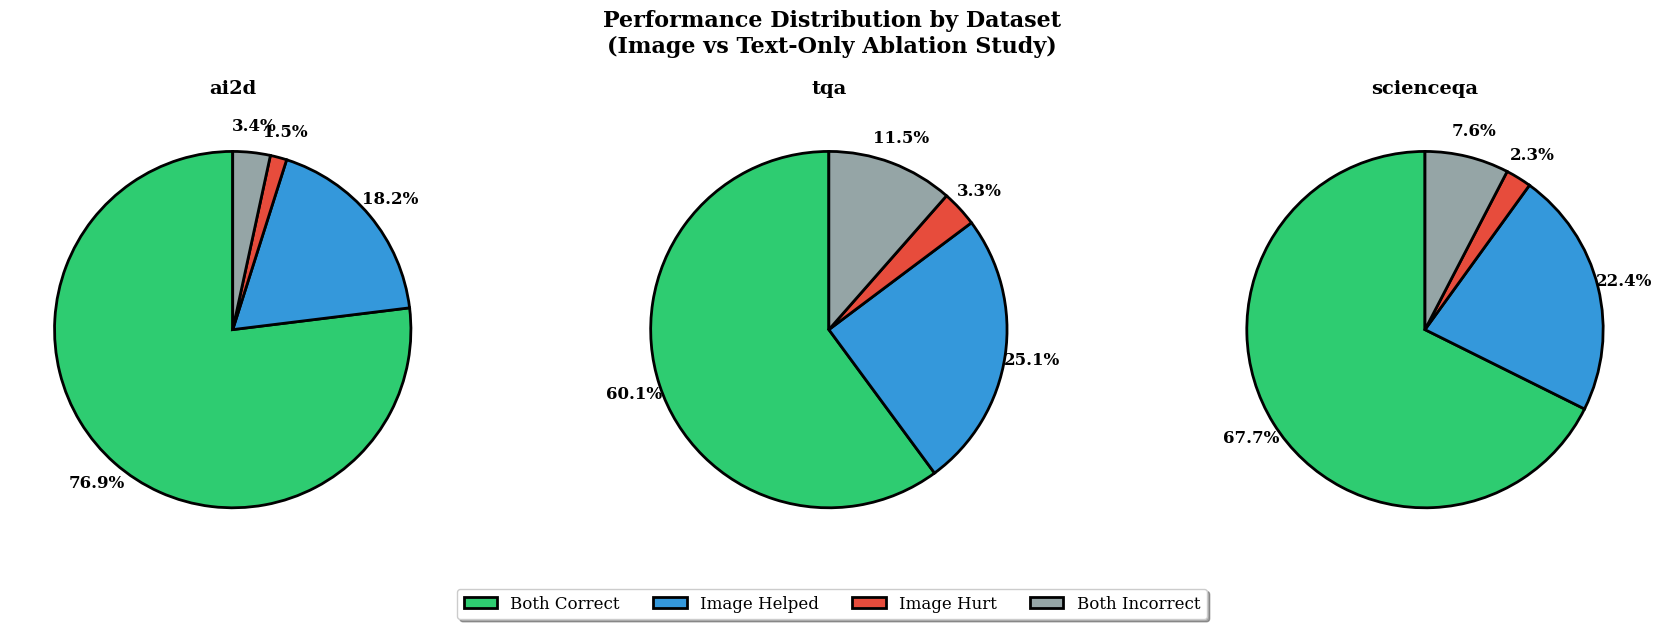


=== Distribution by Subset ===

ai2d:
  Both Correct: 76.9% (5742 samples)
  Image Helped: 18.2% (1355 samples)
  Image Hurt: 1.5% (112 samples)
  Both Incorrect: 3.4% (253 samples)
  Net image contribution: 16.7%

tqa:
  Both Correct: 60.1% (3896 samples)
  Image Helped: 25.1% (1629 samples)
  Image Hurt: 3.3% (213 samples)
  Both Incorrect: 11.5% (744 samples)
  Net image contribution: 21.8%

scienceqa:
  Both Correct: 67.7% (4160 samples)
  Image Helped: 22.4% (1376 samples)
  Image Hurt: 2.3% (144 samples)
  Both Incorrect: 7.6% (469 samples)
  Net image contribution: 20.0%


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create pie charts for each subset
print("\n=== Creating Pie Charts for Each Subset ===")

# Convert to pandas for easier plotting
df_pandas = df_results.to_pandas()

# Define colors and order
quadrant_order = ['Both Correct', 'Image Helped', 'Image Hurt', 'Both Incorrect']
colors = {
    'Both Correct': '#2ecc71',
    'Image Helped': '#3498db',
    'Image Hurt': '#e74c3c',
    'Both Incorrect': '#95a5a6'
}
colors_list = [colors[q] for q in quadrant_order]

# Get unique subsets
subsets = df_pandas['subset'].unique()
n_subsets = len(subsets)

# Create figure with subplots
fig, axes = plt.subplots(1, n_subsets, figsize=(6*n_subsets, 6))
if n_subsets == 1:
    axes = [axes]

# Create a pie chart for each subset
for idx, subset in enumerate(subsets):
    ax = axes[idx]
    
    # Get data for this subset
    subset_data = df_pandas[df_pandas['subset'] == subset]
    
    # Prepare data in the correct order
    sizes = []
    for q in quadrant_order:
        row = subset_data[subset_data['quadrant'] == q]
        if len(row) > 0:
            sizes.append(row['percentage'].values[0])
        else:
            sizes.append(0)
    
    # Create pie chart with percentages outside
    wedges, texts, autotexts = ax.pie(
        sizes,
        colors=colors_list,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 2},
        pctdistance=1.15  # Move percentages outside the circle
    )
    
    # Make percentage text more visible (now outside the pie)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    
    ax.set_title(f'{subset}', fontsize=14, fontweight='bold', pad=10)

# Add overall title
fig.suptitle('Performance Distribution by Dataset\n(Image vs Text-Only Ablation Study)',
             fontsize=16, fontweight='bold', y=0.98)

# Create legend at the bottom
fig.legend(quadrant_order, loc='lower center', ncol=4, fontsize=12, 
           frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Print summary for each subset
print("\n=== Distribution by Subset ===")
for subset in subsets:
    print(f"\n{subset}:")
    subset_data = df_pandas[df_pandas['subset'] == subset]
    for q in quadrant_order:
        row = subset_data[subset_data['quadrant'] == q]
        if len(row) > 0:
            pct = row['percentage'].values[0]
            cnt = row['count'].values[0]
            print(f"  {q}: {pct:.1f}% ({cnt} samples)")
    
    # Calculate net image contribution
    helped = subset_data[subset_data['quadrant'] == 'Image Helped']['percentage'].values
    hurt = subset_data[subset_data['quadrant'] == 'Image Hurt']['percentage'].values
    helped_val = helped[0] if len(helped) > 0 else 0
    hurt_val = hurt[0] if len(hurt) > 0 else 0
    print(f"  Net image contribution: {helped_val - hurt_val:.1f}%")


In [ ]:
# Create a summary DataFrame with the distribution data
summary_data = []
for subset in subsets:
    subset_data = df_pandas[df_pandas['subset'] == subset]
    row = {'Subset': subset}
    
    for q in quadrant_order:
        q_data = subset_data[subset_data['quadrant'] == q]
        if len(q_data) > 0:
            pct = q_data['percentage'].values[0]
            cnt = q_data['count'].values[0]
            row[q] = f"{pct:.1f}% ({cnt})"
        else:
            row[q] = "0.0% (0)"
    
    # Calculate net image impact
    helped = subset_data[subset_data['quadrant'] == 'Image Helped']['percentage'].values
    hurt = subset_data[subset_data['quadrant'] == 'Image Hurt']['percentage'].values
    helped_val = helped[0] if len(helped) > 0 else 0
    hurt_val = hurt[0] if len(hurt) > 0 else 0
    row['Net Image Impact'] = f"{helped_val - hurt_val:+.1f}%"
    
    summary_data.append(row)

# Convert to Daft DataFrame
summary_df = daft.from_pydict({
    col: [row[col] for row in summary_data]
    for col in summary_data[0].keys()
})

print("\n=== Performance Distribution Summary ===")
summary_df



SubsetString,Both CorrectString,Image HelpedString,Image HurtString,Both IncorrectString,Net Image ImpactString
ai2d,76.9% (5742),18.2% (1355),1.5% (112),3.4% (253),+16.7%
tqa,60.1% (3896),25.1% (1629),3.3% (213),11.5% (744),+21.8%
scienceqa,67.7% (4160),22.4% (1376),2.3% (144),7.6% (469),+20.0%


# 6. Scale with Daft Cloud

**Everything above runs locally on 50 rows.**

But The Cauldron contains **millions of rows across 50 subsets**. To run this evaluation at scale without running into rate limits, tedious GPU configuration, or a sky-high bill you need [Daft Cloud](https://daft.ai/cloud). 

👉 [**Sign up for early access**](https://daft.ai/cloud) | [**Book a demo**](https://www.daft.ai/demo) 

---

### Take this one step further with LLM-as-a-judge
For a daft cloud ready-to-run script with a bonus LLM-as-a-judge section, check out [`eval_image_understanding.py`](https://github.com/Eventual-Inc/daft-examples/blob/dc/canon/eval_image_understanding.py) in the [daft-examples](https://github.com/Eventual-Inc/daft-examples) repo. 


## 10. Conclusion

In this notebook, we built a small pipeline to evaluate Qwen3-VL's image understanding:

1. **Structured Outputs**: Used Pydantic models to enforce consistent responses
2. **Ablation Study**: Isolated image understanding from general reasoning
3. **Quadrant Analysis**: Classified results into actionable categories
R
### Next Steps

**Multi-Dataset Evaluation**: Extend across all 50 Cauldron subsets
```python
subsets = ["ai2d", "chartqa", "docvqa", "infographicvqa", ...]
for subset in subsets:
    df = run_full_pipeline(subset, MODEL_ID)
    df.write_parquet(f"results/{subset}.parquet")
```

**Experiment Tracking**: Wire judge feedback into MLflow or W&B to track improvements over time.

**RLVR Training**: Use the `is_correct` signal and judge attributions for reinforcement learning with verifiable rewards.

---

### Resources

- [Daft Documentation](https://docs.daft.ai)
- [Daft Cloud](https://daft.ai/cloud)
- [The Cauldron Dataset](https://huggingface.co/datasets/HuggingFaceM4/the_cauldron)
- [Qwen3-VL](https://github.com/QwenLM/Qwen3-VL)

**Canonical References:**
- [Getting Structured LLM Output (DeepLearning.ai)](https://learn.deeplearning.ai/courses/getting-structured-llm-output/information)
- [Judging LLM-as-a-Judge (NeurIPS 2023)](https://arxiv.org/abs/2306.05685)


